# Machine Learning and AI for Autonomous Systems
## A program by IISc and TalentSprint
### Assignment: n-step Bootstrapping

## Learning Objectives

At the end of the experiment, you will be able to:

* understand the n-step Bootstrapping
* implement n-step Sarsa using LunarLander environment

### Setup Steps:

In [36]:
#@title Please enter your registration id to start: { run: "auto", display-mode: "form" }
Id = "2302794" #@param {type:"string"}

In [37]:
#@title Please enter your password (your registered phone number) to continue: { run: "auto", display-mode: "form" }
password = "9008710123" #@param {type:"string"}

In [39]:
#@title Run this cell to complete the setup for this Notebook
from IPython import get_ipython

ipython = get_ipython()

notebook= "AIAS_B2_M4_AST_05_n_Step_Bootstrapping_C" #name of the notebook

def setup():
#  ipython.magic("sx pip3 install torch")
    ipython.magic("sx wget https://files.grouplens.org/datasets/movielens/ml-25m.zip")
    ipython.magic("sx unzip ml-25m.zip")
    from IPython.display import HTML, display
    display(HTML('<script src="https://dashboard.talentsprint.com/aiml/record_ip.html?traineeId={0}&recordId={1}"></script>'.format(getId(),submission_id)))
    print("Setup completed successfully")
    return

def submit_notebook():
    ipython.magic("notebook -e "+ notebook + ".ipynb")

    import requests, json, base64, datetime

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook, "mobile" : getPassword()}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:
        print(r["err"])
        return None
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None

    elif getAnswer() and getComplexity() and getAdditional() and getConcepts() and getComments() and getMentorSupport():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional,
              "concepts" : Concepts, "record_id" : submission_id,
              "answer" : Answer, "id" : Id, "file_hash" : file_hash,
              "notebook" : notebook,
              "feedback_experiments_input" : Comments,
              "feedback_mentor_support": Mentor_support}
      r = requests.post(url, data = data)
      r = json.loads(r.text)
      if "err" in r:
        print(r["err"])
        return None
      else:
        print("Your submission is successful.")
        print("Ref Id:", submission_id)
        print("Date of submission: ", r["date"])
        print("Time of submission: ", r["time"])
        print("View your submissions: https://aias-iisc.talentsprint.com/notebook_submissions")
        #print("For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.")
        return submission_id
    else: submission_id


def getAdditional():
  try:
    if not Additional:
      raise NameError
    else:
      return Additional
  except NameError:
    print ("Please answer Additional Question")
    return None

def getComplexity():
  try:
    if not Complexity:
      raise NameError
    else:
      return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None

def getConcepts():
  try:
    if not Concepts:
      raise NameError
    else:
      return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None


# def getWalkthrough():
#   try:
#     if not Walkthrough:
#       raise NameError
#     else:
#       return Walkthrough
#   except NameError:
#     print ("Please answer Walkthrough Question")
#     return None

def getComments():
  try:
    if not Comments:
      raise NameError
    else:
      return Comments
  except NameError:
    print ("Please answer Comments Question")
    return None


def getMentorSupport():
  try:
    if not Mentor_support:
      raise NameError
    else:
      return Mentor_support
  except NameError:
    print ("Please answer Mentor support Question")
    return None

def getAnswer():
  try:
    if not Answer:
      raise NameError
    else:
      return Answer
  except NameError:
    print ("Please answer Question")
    return None


def getId():
  try:
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup()
else:
  print ("Please complete Id and Password cells before running setup")



Setup completed successfully


## Introduction

Neither the Monte Carlo (MC) methods nor one-step TD methods are always the best. **n-step TD methods** generalize both methods so that one can shift from one to the other smoothly as needed to meet the demands of a particular task. n-step methods span a spectrum with MC methods at one end and one-step TD methods at the other. The best methods are often intermediate between the two extremes.

Benefit of n-step methods is that they free us from the tyranny of the time step. With one-step TD methods the same time step determines how often the action can be changed and the time interval over which bootstrapping is done. In many applications one wants to be able to update the action very fast to
take into account anything that has changed, but bootstrapping works best if it is over a length of time in which a significant and recognizable state change has occurred. With one-step TD methods, these time intervals are the same, and so a compromise must be made. n-step methods enable bootstrapping to occur over multiple steps, freeing us from the tyranny of the single time step.


### **n-step TD Prediction**

Monte Carlo methods perform an update for each state based on the entire sequence of observed rewards from that state until the end of the episode.

The update of one-step TD methods, on the other hand, is based on just the one next reward, bootstrapping from the value of the state one step later as a proxy for the remaining rewards.

One kind of intermediate method, then, would perform an update based on an intermediate number of rewards: more than one, but less than all of them until termination. For example, a two-step update would be based on the first two rewards and the estimated value of the state two steps later. Similarly, we could have three-step updates, four-step updates, and so on.

Figure below shows the backup diagrams of the spectrum of n-step updates for value function, with the one-step TD update on the left and the up-until-termination Monte Carlo update on the right.

(Empty circles represents states, and filled dots represents actions)

<img src="https://cdn.iisc.talentsprint.com/AIAS/n-step_methods.png" width=450px>
<br><br>

The methods that use n-step updates are still TD methods because they still change an earlier estimate based on how it differs from a later estimate. Now the later estimate is not one step later, but n steps later. Methods in which the temporal difference extends over n steps are called ***n-step TD methods***.

### **Which value of $n$ is better?**

Unfortunately, there is no theoretically best value for $n$. It depends on the particular application and reward function that is being trained. In practice, it seems that values of around 4-8 give good updates because we can easily assign credit to each of the 4-8 actions; that is, we can tell whether the 4-8 actions in the lookahead contributed to the score, as we use the TD estimates.

The figure given below shows the results of a simple empirical test for
a larger random walk process, with 19 states. Results are shown for n-step TD methods with a range of values for $n$ and $\alpha$.

<img src="https://cdn.iisc.talentsprint.com/AIAS/n-step_td_randomwalk.png" width=550px>
<br><br>

The performance measure for each parameter setting, shown on the vertical axis, is the square-root of the average squared error between the predictions at the end of the episode for the 19 states and their true values, then averaged over the first 10 episodes and 100 repetitions of the whole experiment (the same sets of walks were used for all parameter settings). Note that methods with an intermediate value of $n$ worked best. This illustrates how the generalization of TD and Monte Carlo methods to n-step methods can potentially perform better than either of the two extreme methods.

## **n-step Sarsa**

n-step methods can be combined with Sarsa to produce an on-policy TD control method. The n-step version of Sarsa cab be called n-step Sarsa, and the original version can be called one-step Sarsa, or Sarsa(0).

The main idea is to simply switch states for actions (state-action pairs) and then use an $\epsilon$-greedy policy. The diagrams for n-step Sarsa, shown below, are strings of alternating states and actions, except that the they all start and end with an action rather a state.

<img src="https://cdn.iisc.talentsprint.com/AIAS/n-step_sarsa_diagram.png" width=550px>
<br><br>

Redefined n-step returns (update targets) in terms of estimated action values:

$G_{t:t+n} = R_{t+1} + \gamma R_{t+2} + ··· + \gamma^{n-1} R_{t+n} + \gamma^{n}Q_{t+n-1}(S_{t+n}, A_{t+n}), \quad \quad \quad n\ge1, \quad 0 < t < T-n,$

with $G_{t:t+n} = G_t$ if $t + n \ge T$.

The natural algorithm is then

$Q_{t+n}(S_t, A_t) = Q_{t+n-1}(S_t, A_t) + \alpha [G_{t:t+n} - Q_{t+n-1}(S_t, A_t)] , \quad \quad \quad   0 \le t < T,$

while the values of all other states remain unchanged: $Q_{t+n}(s, a) = Q_{t+n-1}(s, a)$, for all $s$, $a$ such that $s \ne S_t$ or $a \ne A_t$.

This algorithm is called *n-step Sarsa*.


### Pseudocode to implement $n$-step Sarsa

<img src="https://cdn.iisc.talentsprint.com/AIAS/n-step_sarsa_algorithm.png" width=650px>

### Building AI solution with n-step Sarsa method

Let's see the implementation of the n-step Sarsa method with *Lunar Lander* example.

### Import required packages

In [40]:
!pip -q install swig
!pip -q install gymnasium
!pip -q install gymnasium[box2d]

In [41]:
import gymnasium as gym
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
mpl.rc('animation', html='jshtml')
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

## Example: Lunar Lander

Here, the task is to teach the lander, to land safely between the two flags without crashing, using n-step Sarsa method.

<br>
<center>
<img src="https://cdn.iisc.talentsprint.com/AIAS/lunar_lander.gif" width=500px>
</center>
<br>

This environment is a classic rocket trajectory optimization problem. According to Pontryagin's maximum principle, it is optimal to fire the engine at full throttle or turn it off. This is the reason why this environment has discrete actions: engine on or off.

There are two environment versions: discrete or continuous. The landing pad is always at coordinates (0,0). The coordinates are the first two numbers in the state vector. Landing outside of the landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt.

<br>

Let's see the details of different aspects, such as rewards, states, and actions, that needs to be considered while modeling an RL solution for this problem.


### **Actions**

There are four discrete actions available::

- 0: do nothing
- 1: fire left orientation engine
- 2: fire main engine
- 3: fire right orientation engine

### **States** (Observations)

The state is an 8-dimensional vector:
- the coordinates of the lander in x & y,
- its linear velocities in x & y,
- its angle,
- its angular velocity, and
- two booleans that represent whether each leg is in contact with the ground or not.

### **Rewards**

After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

- is increased/decreased the closer/further the lander is to the landing pad.
- is increased/decreased the slower/faster the lander is moving.
- is decreased the more the lander is tilted (angle not horizontal).
- is increased by 10 points for each leg that is in contact with the ground.
- is decreased by 0.03 points each frame a side engine is firing.
- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.

### **Starting State**

The lander starts at the top center of the viewport with a random initial force applied to its center of mass.

### **Episode End**

The episode finishes if:

- the lander crashes (the lander body gets in contact with the moon)
- the lander gets outside of the viewport (x coordinate is greater than 1)
- the lander is not awake

To know more about the LunarLander environment, refer [here](https://gymnasium.farama.org/environments/box2d/lunar_lander/).

### Create Environment

An environment can be created using `gym.make()` function. After the environment is created, it must be initialized using the `reset()` method. This returns the first observation/state. Observations depend on the type of environment.

In [42]:
# Create LunarLander environment
env = gym.make("LunarLander-v2",
               continuous= False,           # whether to use the continuous or discrete action environment
               gravity= -10.0,              # gravity: dictates the gravitational constant, this is bounded to be within 0 and -12
               enable_wind= False,          # enable_wind: whether there will be wind effects applied to the lander or not
               wind_power= 15.0,            # wind_power: dictates the maximum magnitude of linear wind applied to the craft. The recommended value between 0.0 and 20.0
               turbulence_power= 1.5,       # turbulence_power: dictates the maximum magnitude of rotational wind applied to the craft. The recommended value between 0.0 and 2.0
               render_mode="rgb_array",)

# Initial state
state_, info = env.reset()
state_

array([-0.0072793 ,  1.4053695 , -0.73733723, -0.24671353,  0.00844177,
        0.16701788,  0.        ,  0.        ], dtype=float32)

In case of LunarLander environment, the state is a 8-dimensional vector.

### Visualize Environment

Let's create a function to visualize the environment.

In [43]:
# Create a function to plot environment

def plot_environment(env):
    img = env.render()              # render() will render the frame/snapshot of environment in current state.
                                     # We want render() to return the rendered image as a NumPy array, that's why
                                     # we set render_mode="rgb_array" while instantiating the environment
                                    # Also, once the render() is called, then the environment either must be reset() or a step() has to be taken before calling the render() again
    plt.imshow(img)
    #plt.axis("off")
    return img


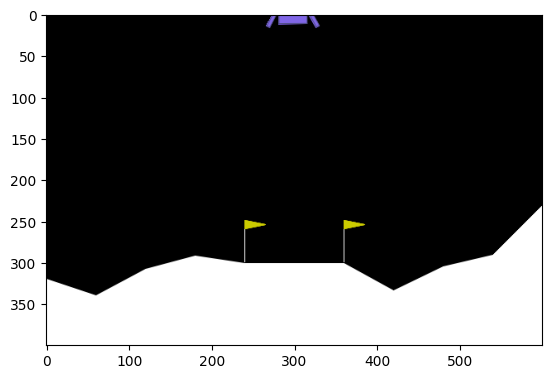

In [44]:
# Visualize environment
env.reset()
plot_environment(env)
plt.show()

In [45]:
# Action and State spaces
print("Action Space:\n {}".format(env.action_space))
print("State Space:\n {}".format(env.observation_space))

Action Space:
 Discrete(4)
State Space:
 Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)


- ***Discrete:*** describes a discrete space where {0, 1, …, n-1} are the possible values our action can take.

- ***Box:*** describes an n-dimensional continuous space. It's a bounded space where we can define the upper and lower limits which describe the valid values our observations can take.

#### Function to make the Observation space discrete

In [46]:
landerXSpace = [-0.1, -0.05, 0.05, 0.1]
landerYSpace = [-0.2, -0.1, 0.1, 0.2]
landerXVelSpace = [-0.2, -0.1, 0.1, 0.2]
landerYVelSpace = [-0.2, -0.1, 0.1, 0.2]
landerThetaSpace = [-0.2, -0.1, 0.1, 0.2]
landerThetaVelSpace = [-0.2, -0.1, 0.1, 0.2]


def discretize_state(observation):
    """
    Given a continuous value for a state vector, this function will assign a integer index to each vector element based on the bin it lies in.
    """
    landerX, landerY, landerXVel, landerYVel, landerTheta, landerThetaVel, landerLeftLeg, landerRightLeg = observation

    landerX = int(np.digitize(landerX, landerXSpace))
    landerY = int(np.digitize(landerY, landerYSpace))
    landerXVel = int(np.digitize(landerXVel, landerXVelSpace))
    landerYVel = int(np.digitize(landerYVel, landerYVelSpace))
    landerTheta = int(np.digitize(landerTheta, landerThetaSpace))
    landerThetaVel = int(np.digitize(landerThetaVel, landerThetaVelSpace))
    landerLeftLeg = int(landerLeftLeg)
    landerRightLeg = int(landerRightLeg)

    return (landerX, landerY, landerXVel, landerYVel, landerTheta, landerThetaVel, landerLeftLeg, landerRightLeg)


In [47]:
# Initial and discretize state
print(f"Initial state: {state_.round(4)}")
print(f"Discretize state: {discretize_state(state_)}")

Initial state: [-0.0073  1.4054 -0.7373 -0.2467  0.0084  0.167   0.      0.    ]
Discretize state: (2, 4, 0, 0, 2, 3, 0, 0)


In [48]:
# List all possible states

states = []

for x in range(len(landerXSpace)+1):
    for y in range(len(landerYSpace)+1):
        for xvel in range(len(landerXVelSpace)+1):
            for yvel in range(len(landerYVelSpace)+1):
                for theta in range(len(landerThetaSpace)+1):
                    for thetavel in range(len(landerThetaVelSpace)+1):
                        for Lleg in range(2):
                            for Rleg in range(2):
                                states.append((x, y, xvel, yvel, theta, thetavel, Lleg, Rleg))

len(states)

62500

In [49]:
# Initialize Q-values
# The Q-table here is a form of dictionary where we have a key for every (state, action) pair.       (62500 x 4 = 250000)
# It's first initialized to 0, and then values are updated during training.

n_actions = env.action_space.n    # =4

Q = {}
for s in states:
    for a in range(n_actions):
        Q[(s, a)] = 0.0

In [50]:
len(Q.keys())

250000

Let's now create the training algorithm, n-step Sarsa, that will update this Q-table as the agent explores the environment over thousands of episodes.

In [51]:
env = gym.make("LunarLander-v2", continuous= False, render_mode="rgb_array")

In [52]:
# n-step SARSA

# Hyperparameters
alpha = 0.05        # Learning rate: Q value update step size
gamma = 0.9         # Discount factor: the factor at which the Q-Value gets decremented after each cycle
epsilon = 1.0       # epsilon to be used by greedy policy
episodes = 50000
n = 4
state_memory = [0 for i in range(n)]
action_memory = [0 for i in range(n)]
reward_memory = [0 for i in range(n)]


# For plotting metrics
all_epochs = []
all_rewards = []


# Update Q-Table using SARSA

for i in range(1, episodes + 1):
    t = 0
    T = np.inf
    # Initial state and reward
    state, info = env.reset()
    state = discretize_state(state)
    state_memory[t%n] = state
    reward = 0
    done = False

    # Using epsilon-greedy policy for selecting the initial action to take
    if random.uniform(0, 1) < epsilon:
        action = env.action_space.sample()   # Explore action space
    else:
        action = np.argmax([Q[state, a] for a in range(env.action_space.n)])   # Exploit learned values

    action_memory[t%n] = action

    epochs, rewards = 0, 0
    count = 0

    while not done:

        if t < T:
            # Take action on environment, and get reward and next-state
            next_state, reward, done, truncated, info = env.step(action)
            next_state = discretize_state(next_state)
            state_memory[(t+1)%n] = next_state
            reward_memory[(t+1)%n] = reward

            if done:
                T = t+1
                #print('episode ends at step', t)
            else:
                # Using epsilon-greedy policy for selecting the next action to take
                if random.uniform(0, 1) < epsilon:
                    next_action = env.action_space.sample()
                else:
                    next_action = np.argmax([Q[next_state, a] for a in range(env.action_space.n)])
                action_memory[(t+1)%n] = next_action

        tau = t - n + 1
        if tau >= 0:
            G = np.sum([gamma**(j-tau-1) * reward_memory[j%n] for j in range(tau+1, min(tau+n, T)+1)])
            if tau+n < T:
                s = state_memory[(tau+n)%n]
                a = action_memory[(tau+n)%n]
                G = G + gamma**n * Q[(s, a)]
            s = state_memory[tau%n]
            a = action_memory[tau%n]
            Q[(s, a)] += alpha * (G - Q[(s,a)])
        #print('tau ', tau, '| Q %.2f' % Q[(state_memory[tau%n], action_memory[tau%n])])

        action = next_action
        epochs += 1
        rewards += reward

        t += 1
        count += 1

        if tau == T-1:
            break
        if count > 2000:
            break

    if epsilon > 0.05:
        epsilon = epsilon - 2/episodes
    else:
        epsilon = 0.05

    all_epochs.append(epochs)
    all_rewards.append(rewards)

    if i % 100 == 0:
        #clear_output(wait=True)
        print(f"Episode: {i}/{episodes}, Epsilon: {np.round(epsilon,2)}, Reward: {np.round(rewards,2)}, Avg_score: {np.mean(all_rewards[-100:]).round(2)}")

print("Training finished.\n")

Episode: 100/50000, Epsilon: 1.0, Reward: -176.36, Avg_score: -159.99
Episode: 200/50000, Epsilon: 0.99, Reward: -216.24, Avg_score: -193.29
Episode: 300/50000, Epsilon: 0.99, Reward: -128.27, Avg_score: -178.94
Episode: 400/50000, Epsilon: 0.98, Reward: -338.02, Avg_score: -195.27
Episode: 500/50000, Epsilon: 0.98, Reward: -139.33, Avg_score: -194.68
Episode: 600/50000, Epsilon: 0.98, Reward: -197.47, Avg_score: -189.45
Episode: 700/50000, Epsilon: 0.97, Reward: -99.5, Avg_score: -179.66
Episode: 800/50000, Epsilon: 0.97, Reward: -30.93, Avg_score: -172.14
Episode: 900/50000, Epsilon: 0.96, Reward: -58.31, Avg_score: -174.7
Episode: 1000/50000, Epsilon: 0.96, Reward: -411.32, Avg_score: -206.45
Episode: 1100/50000, Epsilon: 0.96, Reward: -188.89, Avg_score: -210.31
Episode: 1200/50000, Epsilon: 0.95, Reward: -125.13, Avg_score: -162.74
Episode: 1300/50000, Epsilon: 0.95, Reward: -356.67, Avg_score: -188.3
Episode: 1400/50000, Epsilon: 0.94, Reward: -126.62, Avg_score: -184.65
Episode:

#### Plot metrics

In [54]:
len(all_epochs), len(all_rewards)

(50000, 50000)

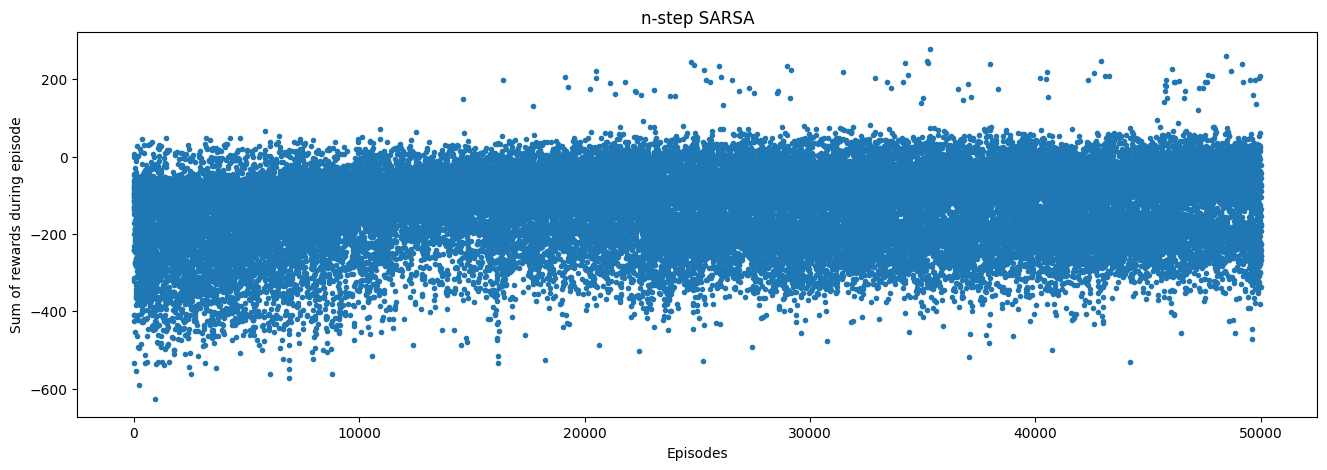

In [55]:
plt.figure(figsize=(16,5))
plt.plot(range(episodes), all_rewards, '.')
plt.xlabel("Episodes")
plt.ylabel("Sum of rewards during episode")
plt.title("n-step SARSA")
plt.show()

From the above plot, it can be seen that at starting episodes rewards are low, but as the training progresses the reward density shifted a little bit high.

Note that the training depends on what values for $n$ and $\alpha$ has been selected. A right pair of $n$ and $\alpha$ will result in higher rewards.

### Visualize performance

To evaluate agent's performance, let's create a function that will return the frames/snapshots of the enviorment as the agent progresses. Also, create functions that will use these frames to create an overall animation.

In [56]:
# Create function to return frames for animation

def render_frames(q_table):
    frames = []
    env = gym.make("LunarLander-v2", continuous= False, render_mode="rgb_array")
    obs = env.reset()[0]
    obs = discretize_state(obs)
    done = False

    while not done:
        img = env.render()
        frames.append(img)
        action = np.argmax([q_table[(obs, a)] for a in range(env.action_space.n)])
        obs, reward, done, truncated, info = env.step(action)
        obs = discretize_state(obs)

    env.close()
    return frames


In [57]:
# Create functions to plot animation

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(fig, update_scene, fargs=(frames, patch),
                                   frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [58]:
# Visualize animation
frames = render_frames(Q)
plot_animation(frames)

Play the above animation to see the agent's progress.

### Please answer the questions below to complete the experiment:




In [59]:
# @title  In SARSA-Max, how is the Q-value of a state-action pair updated during the learning process? { run: "auto", form-width: "500px", display-mode: "form" }
Answer = " By selecting the maximum Q-value over all possible actions in the next state" #@param ["","By directly using the reward received in the current time step"," By selecting the maximum Q-value over all possible actions in the next state", "By propagating the reward through the entire episode", "By using the difference between the observed reward and the predicted reward"]

In [60]:
#@title How was the experiment? { run: "auto", form-width: "500px", display-mode: "form" }
Complexity = "Good and Challenging for me" #@param ["","Too Simple, I am wasting time", "Good, But Not Challenging for me", "Good and Challenging for me", "Was Tough, but I did it", "Too Difficult for me"]


In [61]:
#@title If it was too easy, what more would you have liked to be added? If it was very difficult, what would you have liked to have been removed? { run: "auto", display-mode: "form" }
Additional = "It is good and challenging" #@param {type:"string"}


In [62]:
#@title Can you identify the concepts from the lecture which this experiment covered? { run: "auto", vertical-output: true, display-mode: "form" }
Concepts = "Yes" #@param ["","Yes", "No"]


In [63]:
#@title  Text and image description/explanation and code comments within the experiment: { run: "auto", vertical-output: true, display-mode: "form" }
Comments = "Very Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [ ]:
#@title Mentor Support: { run: "auto", vertical-output: true, display-mode: "form" }
Mentor_support = "Very Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [ ]:
#@title Run this cell to submit your notebook for grading { vertical-output: true }
try:
  if submission_id:
      return_id = submit_notebook()
      if return_id : submission_id = return_id
  else:
      print("Please complete the setup first.")
except NameError:
  print ("Please complete the setup first.")

Your submission is successful.
Ref Id: 983
Date of submission:  28 Jun 2024
Time of submission:  22:49:57
View your submissions: https://aias-iisc.talentsprint.com/notebook_submissions
